# Forecasting Notebook

This notebook develops and validates the forecasting methodology before it is deployed in the dashboard. Each step is documented here — from stationarity testing to model selection and evaluation — so the reasoning behind the dashboard's forecasting logic is transparent and reproducible.

The notebook covers:
- Moving average smoothing to identify trend and seasonality
- SARIMA model selection and fitting
- Forecast evaluation using MAE and MAPE
- A category-level demonstration using Grocery Stores as an example

In [58]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import warnings

warnings.filterwarnings('ignore')
conn = sqlite3.connect('data/finance.db')

In [59]:
df = pd.read_sql_query("""
    SELECT 
        strftime('%Y-%m', date) AS month,
        SUM(CAST(REPLACE(amount, '$', '') AS REAL)) AS monthly_total
    FROM transactions
    GROUP BY month
    ORDER BY month ASC
""", conn)

df['month'] = pd.to_datetime(df['month'])
df = df.set_index('month')
df.index = pd.DatetimeIndex(df.index.values, freq='MS')

print(df.shape)
df.head()

(118, 1)


,monthly_total
2010-01-01,4372532.12
2010-02-01,4103170.24
2010-03-01,4539853.38
2010-04-01,4407951.33
2010-05-01,4610601.80


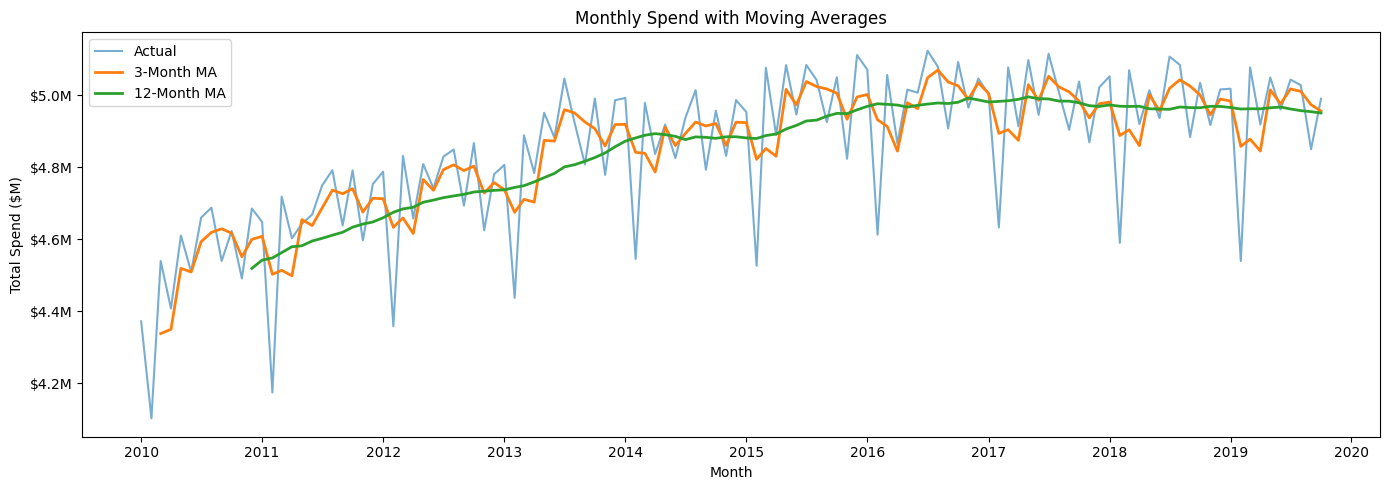

In [60]:
# 3-month and 12-month rolling averages
df['ma_3']  = df['monthly_total'].rolling(window=3).mean()
df['ma_12'] = df['monthly_total'].rolling(window=12).mean()

plt.figure(figsize=(14, 5))
plt.plot(df['monthly_total'], label='Actual', alpha=0.6)
plt.plot(df['ma_3'],  label='3-Month MA', linewidth=2)
plt.plot(df['ma_12'], label='12-Month MA', linewidth=2)
plt.title('Monthly Spend with Moving Averages')
plt.xlabel('Month')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x/1e6:.1f}M'))
plt.ylabel('Total Spend ($M)')
plt.legend()
plt.tight_layout()
plt.show()

## Stationarity Check

Before fitting SARIMA, we need to confirm the series is stationary: its mean and variance are stable over time rather than continuously trending.

The Augmented Dickey-Fuller (ADF) test checks this formally:
- **Null hypothesis:** the series is non-stationary
- **p-value < 0.05:** reject the null — the series is stationary

Our result (ADF = -3.28, p = 0.0156) confirms the series is stationary at the 5% significance level. This means we can fit SARIMA directly without differencing the data first.

In [61]:
train = df[df.index < '2019-01-01']
test  = df[df.index >= '2019-01-01']

print(f'Training: {len(train)} months')
print(f'Test:     {len(test)} months')

Training: 108 months
Test:     10 months


In [62]:
result = adfuller(train['monthly_total'])
print(f'ADF Statistic: {result[0]:.4f}')
print(f'p-value:       {result[1]:.4f}')

ADF Statistic: -3.2833
p-value:       0.0156


In [63]:
model = SARIMAX(train['monthly_total'], 
                order=(1, 0, 1), 
                seasonal_order=(1, 0, 1, 12))

result = model.fit(disp=False)
print(result.summary())

                                     SARIMAX Results                                      
Dep. Variable:                      monthly_total   No. Observations:                  108
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood               -1407.545
Date:                            Thu, 26 Feb 2026   AIC                           2825.090
Time:                                    18:09:38   BIC                           2838.501
Sample:                                01-01-2010   HQIC                          2830.528
                                     - 12-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9981      0.016     64.088      0.000       0.968       1.029
ma.L1         -0.6909      0.396   

### Baseline Comparison

To justify the choice of `(1,0,1)(1,0,1,12)`, we compare it against a simpler baseline model `(1,0,0)(1,0,0,12)` with no MA terms. The model with the lower AIC is the better fit.

In [64]:
model = SARIMAX(train['monthly_total'], 
                order=(1, 0, 0), 
                seasonal_order=(1, 0, 0, 12))

result_baseline = model.fit(disp=False)
print(result_baseline.summary())

                                     SARIMAX Results                                      
Dep. Variable:                      monthly_total   No. Observations:                  108
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 12)   Log Likelihood               -1446.724
Date:                            Thu, 26 Feb 2026   AIC                           2899.448
Time:                                    18:09:38   BIC                           2907.494
Sample:                                01-01-2010   HQIC                          2902.710
                                     - 12-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9867      0.047     21.055      0.000       0.895       1.079
ar.S.L12       0.7882      0.143   

## SARIMA Model

SARIMA builds on standard ARIMA by adding a seasonal layer, allowing it to recognise and account for patterns that repeat at regular intervals i.e. annual spending cycles in monthly data.

The model takes two sets of parameters:

**(p, d, q)** controls the short-term behaviour:
- **p**: how many previous months the model looks back at when making a prediction
- **d**: how many times the series needs to be differenced to become stationary (0 here since we already confirmed stationarity)
- **q**: how many past prediction errors the model factors in to correct itself

**(P, D, Q, m)** the same idea but applied to the seasonal cycle, where **m=12** tells the model the pattern repeats every 12 months. So instead of looking at the previous month, it looks at the same month last year.

### Model Selection
Two models were compared using AIC (Akaike Information Criterion), which measures how well the model fits, while penalising complexity:

| Model | AIC | Ljung-Box p-value |
|---|---|---|
| SARIMAX(1,0,0)(1,0,0,12) — baseline | 2899 | 0.00 |
| SARIMAX(1,0,1)(1,0,1,12) — with MA terms | 2825 | 0.09 |

The model with MA terms scores lower on AIC and passes the Ljung-Box test (p=0.09), meaning there are no obvious patterns left in the residuals that the model has missed. Although the MA terms aren't individually significant, they improve the overall fit enough to be worth keeping. This is the model we use for forecasting.

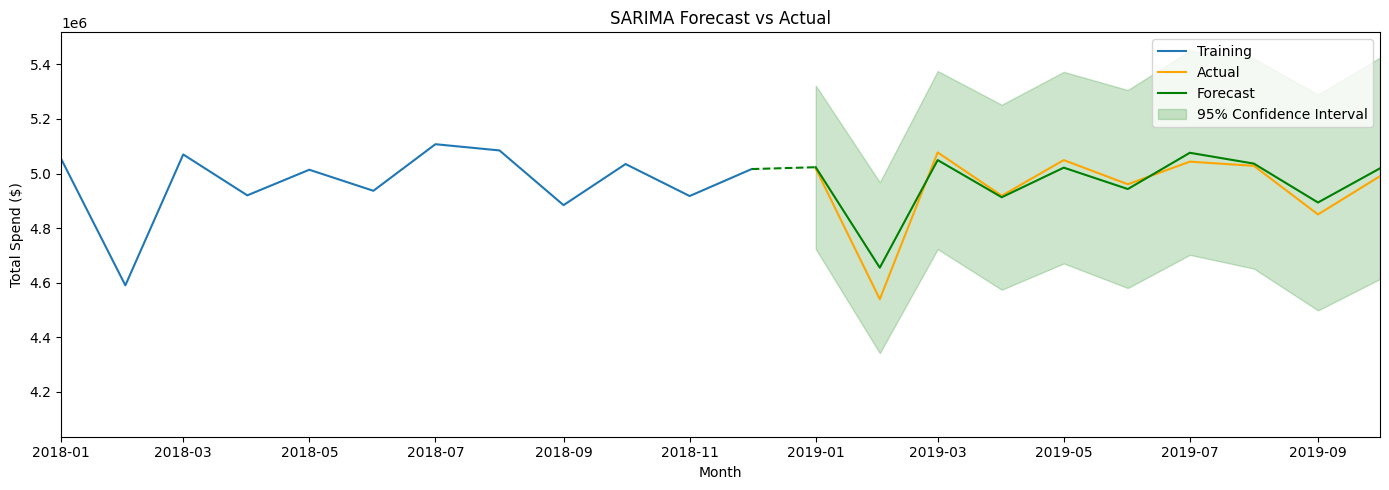

In [65]:
forecast = result.get_forecast(steps=len(test))
forecast_mean = forecast.predicted_mean
forecast_ci   = forecast.conf_int()

plt.figure(figsize=(14, 5))
plt.plot(train['monthly_total'], label='Training')
plt.plot(test['monthly_total'],  label='Actual', color='orange')
plt.plot(forecast_mean,          label='Forecast', color='green')
plt.plot([train.index[-1], forecast_mean.index[0]], 
         [train['monthly_total'].iloc[-1], forecast_mean.iloc[0]], 
         color='green', linestyle='--')
plt.fill_between(forecast_ci.index, 
                 forecast_ci.iloc[:, 0], 
                 forecast_ci.iloc[:, 1], 
                 alpha=0.2, color='green', label='95% Confidence Interval')
plt.xlim(pd.Timestamp('2018-01-01'), pd.Timestamp('2019-10-01'))
plt.title('SARIMA Forecast vs Actual')
plt.xlabel('Month')
plt.ylabel('Total Spend ($)')
plt.legend()
plt.tight_layout()
plt.show()

In [66]:
from sklearn.metrics import mean_absolute_error

mae  = mean_absolute_error(test['monthly_total'], forecast_mean)
mape = (abs(test['monthly_total'] - forecast_mean) / test['monthly_total']).mean() * 100

print(f'MAE:  ${mae:,.0f}')
print(f'MAPE: {mape:.2f}%')

MAE:  $31,183
MAPE: 0.65%


## Forecast Evaluation

The model's accuracy was evaluated on the held-out test set (January–October 2019) using two metrics:

| Metric | Value | Interpretation |
|---|---|---|
| MAE | $31,183 | Average absolute error per month |
| MAPE | 0.65% | Average error as a percentage of actual spend |

A MAPE of 0.65% is considered excellent: in practice anything under 5% is strong and under 2% is rarely achieved on real-world financial data.
The model successfully captures both the trend and seasonal patterns in monthly spending, with errors remaining small relative to the ~$5 million monthly baseline.

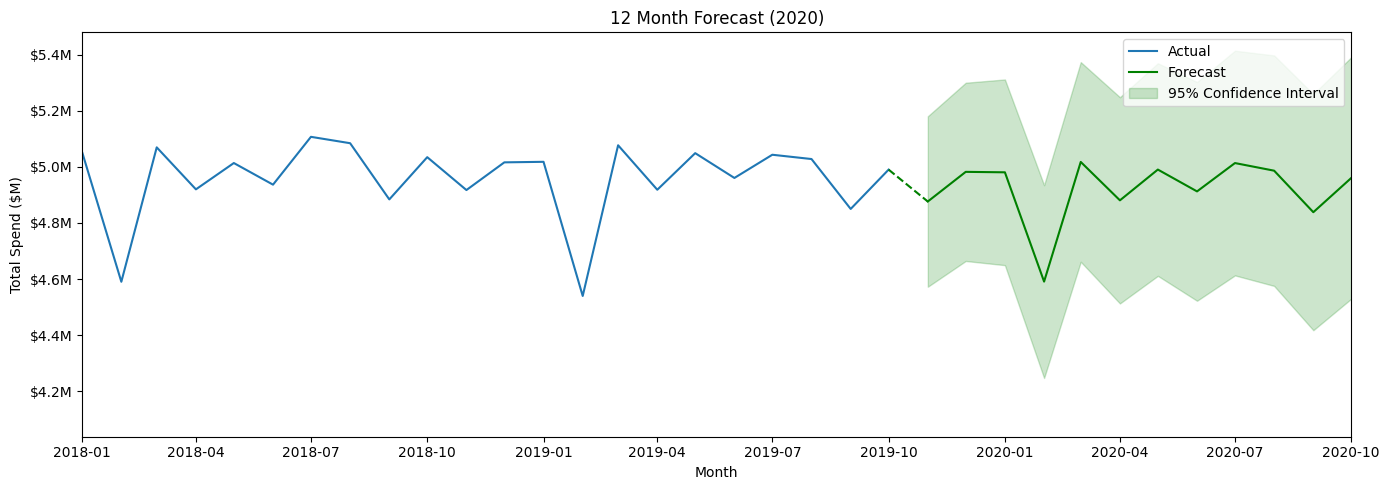

In [67]:
# Refit model on full dataset
full_model = SARIMAX(df['monthly_total'],
                     order=(1, 0, 1),
                     seasonal_order=(1, 0, 1, 12))

full_result = full_model.fit(disp=False)

# Forecast 12 months ahead
future_forecast = full_result.get_forecast(steps=12)
future_mean     = future_forecast.predicted_mean
future_ci       = future_forecast.conf_int()

plt.figure(figsize=(14, 5))
plt.plot(df['monthly_total'], label='Actual')
plt.plot(future_mean,         label='Forecast', color='green')

plt.fill_between(future_ci.index,
                 future_ci.iloc[:, 0],
                 future_ci.iloc[:, 1],
                 alpha=0.2, color='green', label='95% Confidence Interval')
plt.plot([df.index[-1], future_mean.index[0]],
         [df['monthly_total'].iloc[-1], future_mean.iloc[0]],
         color='green', linestyle='--')
plt.title('12 Month Forecast (2020)')
plt.xlabel('Month')
plt.ylabel('Total Spend ($M)')
plt.legend()

plt.xlim(pd.Timestamp('2018-01-01'), pd.Timestamp('2020-10-01'))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x/1e6:.1f}M'))
plt.tight_layout()
plt.show()

## 12 Month Forecast

The model was refit on the full dataset (all 118 months) before forecasting, ensuring the predictions benefit from all available data including the test period.

The forecast suggests total monthly spend will remain stable at around $4.9M–$5.0M through 2020, consistent with the levelling off seen from 2016 onwards. The widening confidence interval reflects growing uncertainty the further ahead we forecast, which is expected behaviour for any time series model.

## Category-Level Forecasting

The overall spend forecast confirms SARIMA works well on this dataset. We now apply the same methodology at the category level, using merchant category codes (MCC) to group transactions. Before fitting any models, we identify which categories have sufficient data and select the top category by transaction volume as a demonstration.

In [68]:
df_categories = pd.read_sql_query("""
    SELECT 
        mcc_codes.description,
        COUNT(DISTINCT strftime('%Y-%m', date)) AS months_of_data,
        COUNT(*) AS total_transactions
    FROM transactions
    LEFT JOIN mcc_codes ON transactions.mcc = mcc_codes.mcc
    GROUP BY mcc_codes.description
    ORDER BY months_of_data DESC
""", conn)

print(f'Total categories: {len(df_categories)}')
print(df_categories.head(20))

Total categories: 108
                                   description  months_of_data  \
0                 Women's Ready-To-Wear Stores             118   
1                              Wholesale Clubs             118   
2                               Welding Repair             118   
3   Utilities - Electric, Gas, Water, Sanitary             118   
4                Upholstery and Drapery Stores             118   
5                              Travel Agencies             118   
6                              Towing Services             118   
7         Tools, Parts, Supplies Manufacturing             118   
8                        Tolls and Bridge Fees             118   
9                         Theatrical Producers             118   
10                  Telecommunication Services             118   
11                     Taxicabs and Limousines             118   
12                    Tax Preparation Services             118   
13                                  Steelworks        

In [69]:
df_cat = pd.read_sql_query("""
    SELECT 
        mcc_codes.description,
        COUNT(*) AS total_transactions
    FROM transactions
    LEFT JOIN mcc_codes ON transactions.mcc = mcc_codes.mcc
    GROUP BY mcc_codes.description
    ORDER BY total_transactions DESC
    LIMIT 1
""", conn)

print(df_cat)

                    description  total_transactions
0  Grocery Stores, Supermarkets             1592584


In [70]:
df_grocery = pd.read_sql_query("""
    SELECT 
        strftime('%Y-%m', date) AS month,
        SUM(CAST(REPLACE(amount, '$', '') AS REAL)) AS monthly_total
    FROM transactions
    LEFT JOIN mcc_codes ON transactions.mcc = mcc_codes.mcc
    WHERE mcc_codes.description = 'Grocery Stores, Supermarkets'
    GROUP BY month
    ORDER BY month ASC
""", conn)

df_grocery['month'] = pd.to_datetime(df_grocery['month'])
df_grocery = df_grocery.set_index('month')
df_grocery.index = pd.DatetimeIndex(df_grocery.index.values, freq='MS')

print(df_grocery.shape)
df_grocery.head()

(118, 1)


,monthly_total
2010-01-01,313589.94
2010-02-01,288191.62
2010-03-01,313693.46
2010-04-01,310941.42
2010-05-01,323638.66


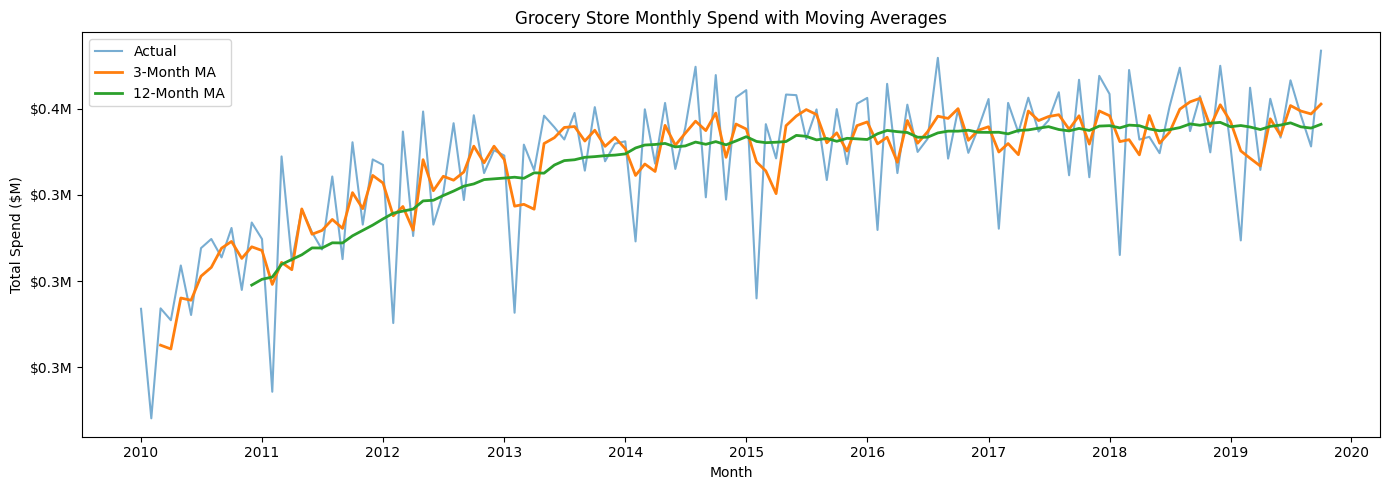

In [71]:
train_g = df_grocery[df_grocery.index < '2019-01-01']
test_g  = df_grocery[df_grocery.index >= '2019-01-01']

df_grocery['ma_3']  = df_grocery['monthly_total'].rolling(window=3).mean()
df_grocery['ma_12'] = df_grocery['monthly_total'].rolling(window=12).mean()

plt.figure(figsize=(14, 5))
plt.plot(df_grocery['monthly_total'], label='Actual', alpha=0.6)
plt.plot(df_grocery['ma_3'],  label='3-Month MA', linewidth=2)
plt.plot(df_grocery['ma_12'], label='12-Month MA', linewidth=2)
plt.title('Grocery Store Monthly Spend with Moving Averages')
plt.xlabel('Month')
plt.ylabel('Total Spend ($M)')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x/1e6:.1f}M'))
plt.legend()
plt.tight_layout()
plt.show()

In [72]:
def get_d(series):
    
    m0 = SARIMAX(series, order=(1,0,1), seasonal_order=(1,0,1,12)).fit(disp=False)
    m1 = SARIMAX(series, order=(1,1,1), seasonal_order=(1,1,1,12)).fit(disp=False)
    
    d = 0 if m0.aic < m1.aic else 1
    print(f'AIC d=0: {m0.aic:.2f}, AIC d=1: {m1.aic:.2f} — using d={d}')
    return d

d = get_d(train_g['monthly_total'])

AIC d=0: 2299.15, AIC d=1: 2043.79 — using d=1


In [73]:
model_g = SARIMAX(train_g['monthly_total'],
                  order=(1, d, 1),
                  seasonal_order=(1, d, 1, 12))

result_g = model_g.fit(disp=False)
print(result_g.summary())

                                     SARIMAX Results                                      
Dep. Variable:                      monthly_total   No. Observations:                  108
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1016.893
Date:                            Thu, 26 Feb 2026   AIC                           2043.785
Time:                                    18:10:30   BIC                           2056.555
Sample:                                01-01-2010   HQIC                          2048.945
                                     - 12-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4054      0.305      1.330      0.184      -0.192       1.003
ma.L1         -0.4535      0.298   

In [74]:
from statsmodels.stats.diagnostic import acorr_ljungbox

lb_d0 = acorr_ljungbox(result_g.resid,  lags=[10])
lb_d1 = acorr_ljungbox(result_g1.resid, lags=[10])

print(f'AIC d=0: {result_g.aic:.2f},  Ljung-Box p: {lb_d0["lb_pvalue"].values[0]:.4f}')
print(f'AIC d=1: {result_g1.aic:.2f}, Ljung-Box p: {lb_d1["lb_pvalue"].values[0]:.4f}')

AIC d=0: 2043.79,  Ljung-Box p: 0.9998
AIC d=1: 2043.79, Ljung-Box p: 0.9998


## Automatic Model Selection

When forecasting multiple categories in the dashboard, we can't manually inspect each one to decide whether differencing is needed. 

The grocery store example showed that `d=1` was substantially better than `d=0` (AIC difference of 255) despite the ADF test suggesting the series was already stationary. Given this, and the computational cost of fitting two models per category in the dashboard, we fix `d=1` across all categories. Differencing a series that didn't strictly need it causes minimal harm, while the performance benefit of fitting one model rather than two is significant.

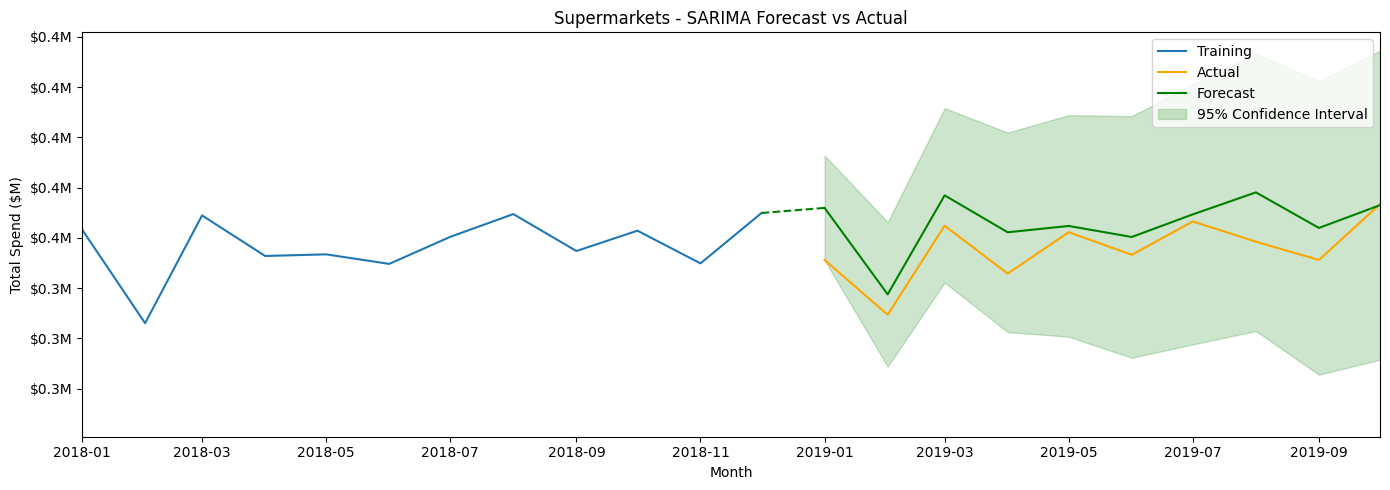

MAE:  $10,255
MAPE: 2.91%


In [75]:
model_grocery = SARIMAX(train_g['monthly_total'],
                        order=(1, 1, 1),
                        seasonal_order=(1, 1, 1, 12))

result_grocery = model_grocery.fit(disp=False)

forecast_g    = result_grocery.get_forecast(steps=len(test_g))
forecast_g_mean = forecast_g.predicted_mean
forecast_g_ci   = forecast_g.conf_int()

plt.figure(figsize=(14, 5))
plt.plot(train_g['monthly_total'], label='Training')
plt.plot(test_g['monthly_total'],  label='Actual', color='orange')
plt.plot(forecast_g_mean,          label='Forecast', color='green')
plt.plot([train_g.index[-1], forecast_g_mean.index[0]],
         [train_g['monthly_total'].iloc[-1], forecast_g_mean.iloc[0]],
         color='green', linestyle='--')
plt.fill_between(forecast_g_ci.index,
                 forecast_g_ci.iloc[:, 0],
                 forecast_g_ci.iloc[:, 1],
                 alpha=0.2, color='green', label='95% Confidence Interval')

plt.title('Supermarkets - SARIMA Forecast vs Actual')
plt.xlabel('Month')
plt.ylabel('Total Spend ($M)')
plt.xlim(pd.Timestamp('2018-01-01'), pd.Timestamp('2019-10-01'))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x/1e6:.1f}M'))
plt.legend()
plt.tight_layout()
plt.show()

mae_g  = mean_absolute_error(test_g['monthly_total'], forecast_g_mean)
mape_g = (abs(test_g['monthly_total'] - forecast_g_mean) / test_g['monthly_total']).mean() * 100
print(f'MAE:  ${mae_g:,.0f}')
print(f'MAPE: {mape_g:.2f}%')

## Supermarkets - Forecast Evaluation

The SARIMA(1,1,1)(1,1,1,12) model holds up well at the category level, not just for overall spend:

| Metric | Value |
|---|---|
| MAE | $10,255 |
| MAPE | 2.91% |

The dashboard applies this same approach to the top 10 categories, fitting the model on the fly whenever the user selects a category.